# Cart-pole Balancing Model with Amazon SageMaker on SageMaker Managed Spot Training

The example here is almost the same as [Cart-pole Balancing Model with Amazon SageMaker](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/reinforcement_learning/rl_cartpole_coach/rl_cartpole_coach_gymEnv.ipynb).

This notebook tackles the exact same problem with the same solution, but it has been modified to be able to run using SageMaker Managed Spot infrastructure. SageMaker Managed Spot uses [EC2 Spot Instances](https://aws.amazon.com/ec2/spot/) to run Training at a lower cost.

Please read the original notebook and try it out to gain an understanding of the ML use-case and how it is being solved. We will not delve into that here in this notebook.

The explanations below has been lifted verbatim from [Cart-pole Balancing Model with Amazon SageMaker](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/reinforcement_learning/rl_cartpole_coach/rl_cartpole_coach_gymEnv.ipynb).


---
## Introduction

In this notebook we'll start from the cart-pole balancing problem, where a pole is attached by an un-actuated joint to a cart, moving along a frictionless track. Instead of applying control theory to solve the problem, this example shows how to solve the problem with reinforcement learning on Amazon SageMaker.

1. *Objective*: Prevent the pole from falling over
2. *Environment*: The environment used in this exmaple is part of OpenAI Gym, corresponding to the version of the cart-pole problem described by Barto, Sutton, and Anderson [1]
3. *State*: Cart position, cart velocity, pole angle, pole velocity at tip	
4. *Action*: Push cart to the left, push cart to the right
5. *Reward*: Reward is 1 for every step taken, including the termination step

References

1. AG Barto, RS Sutton and CW Anderson, "Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem", IEEE Transactions on Systems, Man, and Cybernetics, 1983.

## Pre-requisites 

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [1]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import numpy as np
import subprocess
from IPython.display import HTML
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

### Setup S3 bucket

Set up the linkage and authentication to the S3 bucket that you want to use for checkpoint and the metadata. 

In [2]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-west-2-775004277940/


### Define Variables 

We define variables such as the job prefix for the training jobs *and the image path for the container (only when this is BYOC).*

In [3]:
# create unique job name 
job_name_prefix = 'rl-cart-pole-managed-spot'

### Configure where training happens

You can run your RL training jobs on a SageMaker notebook instance or on your own machine. In both of these scenarios, you can run the following in either local or SageMaker modes. The local mode uses the SageMaker Python SDK to run your code in a local container before deploying to SageMaker. This can speed up iterative testing and debugging while using the same familiar Python SDK interface. You just need to set local_mode = True.

In [4]:
# run in local mode?
local_mode = False

if local_mode:
    instance_type = 'local'
else:
    instance_type = "ml.m4.4xlarge"

### Create an IAM role

Either get the execution role when running from a SageMaker notebook instance `role = sagemaker.get_execution_role()` or, when running from local notebook instance, use utils method `role = get_execution_role()` to create an execution role.

In [5]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::775004277940:role/service-role/AmazonSageMaker-ExecutionRole-20190604T105592


### Install docker for `local` mode

In order to work in `local` mode, you need to have docker installed. When running from you local machine, please make sure that you have docker or docker-compose (for local CPU machines) and nvidia-docker (for local GPU machines) installed. Alternatively, when running from a SageMaker notebook instance, you can simply run the following script to install dependenceis.

Note, you can only run a single local notebook at one time.

In [6]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./common/setup.sh

## Setup the environment

Cartpole environment used in this example is part of OpenAI Gym.

## Configure the presets for RL algorithm 

The presets that configure the RL training jobs are defined in the “preset-cartpole-clippedppo.py” file which is also uploaded on the /src directory. Using the preset file, you can define agent parameters to select the specific agent algorithm. You can also set the environment parameters, define the schedule and visualization parameters, and define the graph manager. The schedule presets will define the number of heat up steps, periodic evaluation steps, training steps between evaluations.

These can be overridden at runtime by specifying the RLCOACH_PRESET hyperparameter. Additionally, it can be used to define custom hyperparameters. 

In [7]:
!pygmentize src/preset-cartpole-clippedppo.py

from rl_coach.agents.clipped_ppo_agent import ClippedPPOAgentParameters
from rl_coach.architectures.layers import Dense
from rl_coach.base_parameters import VisualizationParameters, PresetValidationParameters, DistributedCoachSynchronizationType
from rl_coach.core_types import TrainingSteps, EnvironmentEpisodes, EnvironmentSteps, RunPhase
from rl_coach.environments.gym_environment import GymVectorEnvironment, mujoco_v2
from rl_coach.exploration_policies.additive_noise import AdditiveNoiseParameters
from rl_coach.exploration_policies.e_greedy import EGreedyParameters
from rl_coach.filters.observation.observation_normalization_filter import ObservationNormalizationFilter
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import ScheduleParameters
from rl_coach.schedules import LinearSchedule

####################
# Graph Scheduling #
####################

schedule_params = ScheduleParameters()
# schedule_params.improv

## Write the Training Code 

The training code is written in the file “train-coach.py” which is uploaded in the /src directory. 
First import the environment files and the preset files, and then define the main() function. 

In [8]:
!pygmentize src/train-coach.py

from sagemaker_rl.coach_launcher import SageMakerCoachPresetLauncher

class MyLauncher(SageMakerCoachPresetLauncher):

    def default_preset_name(self):
        """This points to a .py file that configures everything about the RL job.
        It can be overridden at runtime by specifying the RLCOACH_PRESET hyperparameter.
        """
        return 'preset-cartpole-dqn'

    def map_hyperparameter(self, name, value):
        """Here we configure some shortcut names for hyperparameters that we expect to use frequently.
        Essentially anything in the preset file can be overridden through a hyperparameter with a name
        like "rl.agent_params.algorithm.etc".
        """
        # maps from alias (key) to fully qualified coach parameter (value)
        mapping = {
                      "discount": "rl.agent_params.algorithm.discount",
                      "evaluation_episodes": "rl.evaluation_steps:EnvironmentEpisodes",
                      "improve_steps": "rl.improve_steps:Tr

## Train the RL model using the Python SDK Script mode

If you are using local mode, the training will run on the notebook instance. When using SageMaker for training, you can select a GPU or CPU instance. The RLEstimator is used for training RL jobs. 

1. Specify the source directory where the environment, presets and training code is uploaded.
2. Specify the entry point as the training code 
3. Specify the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container. 
4. Define the training parameters such as the instance count, job name, S3 path for output and job name. 
5. Specify the hyperparameters for the RL agent algorithm. The RLCOACH_PRESET can be used to specify the RL agent algorithm you want to use. 
6. Define the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks. 

In [9]:
%%time

estimator = RLEstimator(entry_point="train-coach.py",
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        toolkit=RLToolkit.COACH,
                        toolkit_version='0.11.0',
                        framework=RLFramework.MXNET,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        train_use_spot_instances=True,
                        train_max_wait = 7200,
                        train_max_run=3600,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        hyperparameters = {
                          "RLCOACH_PRESET": "preset-cartpole-clippedppo",
                          "rl.agent_params.algorithm.discount": 0.9,
                          "rl.evaluation_steps:EnvironmentEpisodes": 8,
                          "improve_steps": 10000,
                          "save_model": 1
                        }
                    )

estimator.fit(wait=local_mode)

job_name=estimator._current_job_name
print("Job name: {}".format(job_name))

Job name: rl-cart-pole-managed-spot-2019-10-15-01-20-13-348
CPU times: user 124 ms, sys: 23.9 ms, total: 148 ms
Wall time: 361 ms


## Store intermediate training output and model checkpoints 

The output from the training job above is stored on S3. The intermediate folder contains gifs and metadata of the training.

In [20]:
s3_url = "s3://{}/{}".format(s3_bucket,job_name)

if local_mode:
    output_tar_key = "{}/output.tar.gz".format(job_name)
else:
    output_tar_key = "{}/output/output.tar.gz".format(job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
output_url = "s3://{}/{}".format(s3_bucket, output_tar_key)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Output.tar.gz location: {}".format(output_url))
print("Intermediate folder path: {}".format(intermediate_url))
    
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

S3 job path: s3://sagemaker-us-west-2-775004277940/rl-cart-pole-2019-10-11-17-46-15-786
Output.tar.gz location: s3://sagemaker-us-west-2-775004277940/rl-cart-pole-2019-10-11-17-46-15-786/output/output.tar.gz
Intermediate folder path: s3://sagemaker-us-west-2-775004277940/rl-cart-pole-2019-10-11-17-46-15-786/output/intermediate/
Create local folder /tmp/rl-cart-pole-2019-10-11-17-46-15-786


## Visualization

### Plot metrics for training job
We can pull the reward metric of the training and plot it to see the performance of the model over time.

Waiting for s3://sagemaker-us-west-2-775004277940/rl-cart-pole-2019-10-11-17-46-15-786/output/intermediate/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv...


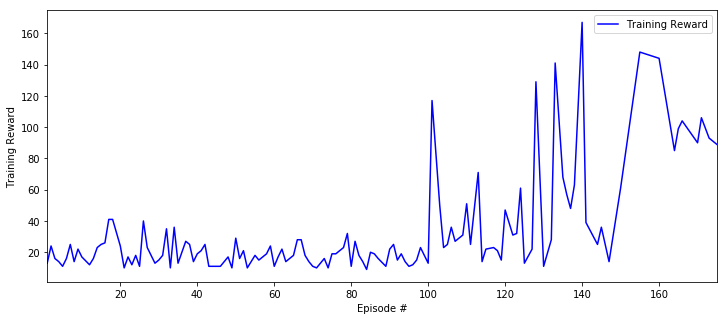

In [21]:
%matplotlib inline
import pandas as pd

csv_file_name = "worker_0.simple_rl_graph.main_level.main_level.agent_0.csv"
key = os.path.join(intermediate_folder_key, csv_file_name)
wait_for_s3_object(s3_bucket, key, tmp_dir, training_job_name=job_name)

csv_file = "{}/{}".format(tmp_dir, csv_file_name)
df = pd.read_csv(csv_file)
df = df.dropna(subset=['Training Reward'])
x_axis = 'Episode #'
y_axis = 'Training Reward'

plt = df.plot(x=x_axis,y=y_axis, figsize=(12,5), legend=True, style='b-')
plt.set_ylabel(y_axis);
plt.set_xlabel(x_axis);

### Visualize the rendered gifs
The latest gif file of the training is displayed. You can replace the gif_index below to visualize other files generated.

In [22]:
key = os.path.join(intermediate_folder_key, 'gifs')
wait_for_s3_object(s3_bucket, key, tmp_dir, training_job_name=job_name)    
print("Copied gifs files to {}".format(tmp_dir))

glob_pattern = os.path.join("{}/*.gif".format(tmp_dir))
gifs = [file for file in glob.iglob(glob_pattern, recursive=True)]
extract_episode = lambda string: int(re.search('.*episode-(\d*)_.*', string, re.IGNORECASE).group(1))
gifs.sort(key=extract_episode)
print("GIFs found:\n{}".format("\n".join([os.path.basename(gif) for gif in gifs])))    

# visualize a specific episode
gif_index = -1 # since we want last gif
gif_filepath = gifs[gif_index]
gif_filename = os.path.basename(gif_filepath)
print("Selected GIF: {}".format(gif_filename))
os.system("mkdir -p ./src/tmp/ && cp {} ./src/tmp/{}.gif".format(gif_filepath, gif_filename))
HTML('<img src="./src/tmp/{}.gif">'.format(gif_filename))

Waiting for s3://sagemaker-us-west-2-775004277940/rl-cart-pole-2019-10-11-17-46-15-786/output/intermediate/gifs...
Copied gifs files to /tmp/rl-cart-pole-2019-10-11-17-46-15-786
GIFs found:
2019-10-11-17-48-40_episode-13_score-9.0.gif
2019-10-11-17-48-40_episode-14_score-10.0.gif
2019-10-11-17-48-42_episode-33_score-11.0.gif
2019-10-11-17-48-45_episode-68_score-13.0.gif
2019-10-11-17-48-58_episode-194_score-164.0.gif
2019-10-11-17-48-59_episode-195_score-200.0.gif
Selected GIF: 2019-10-11-17-48-59_episode-195_score-200.0.gif


## Evaluation of RL models

We use the last checkpointed model to run evaluation for the RL Agent. 

### Load checkpointed model

Checkpointed data from the previously trained models will be passed on for evaluation / inference in the checkpoint channel. In local mode, we can simply use the local directory, whereas in the SageMaker mode, it needs to be moved to S3 first.

In [ ]:
wait_for_s3_object(s3_bucket, output_tar_key, tmp_dir, training_job_name=job_name)  

if not os.path.isfile("{}/output.tar.gz".format(tmp_dir)):
    raise FileNotFoundError("File output.tar.gz not found")
os.system("tar -xvzf {}/output.tar.gz -C {}".format(tmp_dir, tmp_dir))

if local_mode:
    checkpoint_dir = "{}/data/checkpoint".format(tmp_dir)
else:
    checkpoint_dir = "{}/checkpoint".format(tmp_dir)

print("Checkpoint directory {}".format(checkpoint_dir))

In [ ]:
if local_mode:
    checkpoint_path = 'file://{}'.format(checkpoint_dir)
    print("Local checkpoint file path: {}".format(checkpoint_path))
else:
    checkpoint_path = "s3://{}/{}/checkpoint/".format(s3_bucket, job_name)
    if not os.listdir(checkpoint_dir):
        raise FileNotFoundError("Checkpoint files not found under the path")
    os.system("aws s3 cp --recursive {} {}".format(checkpoint_dir, checkpoint_path))
    print("S3 checkpoint file path: {}".format(checkpoint_path))

### Run the evaluation step

Use the checkpointed model to run the evaluation step. 

In [ ]:
estimator_eval = RLEstimator(role=role,
                             source_dir='src/',
                             dependencies=["common/sagemaker_rl"],
                             toolkit=RLToolkit.COACH,
                             toolkit_version='0.11.0',
                             framework=RLFramework.MXNET,
                             entry_point="evaluate-coach.py",
                             train_instance_count=1,
                             train_instance_type=instance_type,
                             hyperparameters = {
                                 "RLCOACH_PRESET": "preset-cartpole-clippedppo",
                                 "evaluate_steps": 2000
                             }
                            )

estimator_eval.fit({'checkpoint': checkpoint_path})

### Visualize the output 

Optionally, you can run the steps defined earlier to visualize the output 

# Model deployment

Since we specified MXNet when configuring the RLEstimator, the MXNet deployment container will be used for hosting.

In [ ]:
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type=instance_type,
                             entry_point='deploy-mxnet-coach.py')

We can test the endpoint with 2 samples observations. Starting with the cart stationary in the center of the environment, but the pole to the right and falling. Since the environment vector was of the form `[cart_position, cart_velocity, pole_angle, pole_velocity]` and we used observation normalization in our preset, we choose an observation of `[0, 0, 2, 2]`. Since we're deploying a PPO model, our model returns both state value and actions.

In [ ]:
value, action = predictor.predict(np.array([0., 0., 2., 2.]))
action

We see the policy decides to move the cart to the right (2nd value) with a higher probability to recover the situation. And similarly in the other direction.

In [ ]:
value, action = predictor.predict(np.array([0., 0., -2., -2.]))
action

### Clean up endpoint

In [ ]:
predictor.delete_endpoint()